In [ ]:
# setting for colab or kaggle
import os
import sys
from duckduckgo_search import DDGS
from fastcore.all import L, Path
from fastai.vision.all import *
from fastdownload import download_url
from time import sleep

isKaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE')
isColab = 'google.colab' in sys.modules

if isKaggle or isColab:
    print('installing packages...')
    !pip install -Uqq fastai
    !pip install -Uqq ddgs

if isColab:
    import os
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install colab_ssh --upgrade
    from colab_ssh import launch_ssh_cloudflared, init_git_cloudflared
    launch_ssh_cloudflared(password="codetocolab")


In [12]:
def search_images(keywords: str, max_images=200):
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')


In [ ]:
urls = search_images('ザキヤマ', max_images=1)
urls[0]


/var/folders/4g/bbm0gjv155936xsdg_41_4080000gn/T/ipykernel_97934/2979004903.py:5: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')


'https://tokyo-sports.ismcdn.jp/mwimgs/f/7/1760w/img_f79b24643a2ed937f0e84c26271f17a716664.jpg'

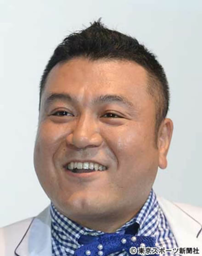

In [ ]:
dest = 'zakiyama.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256, 256)


/var/folders/4g/bbm0gjv155936xsdg_41_4080000gn/T/ipykernel_97934/352026803.py:2: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')


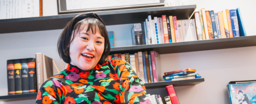

In [13]:
urls = search_images('barbie japanese comedian', max_images=1)
dest = 'barbie.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256, 256)


In [17]:
searches = 'zakiyama japanese comedian', 'barbie japanse comedian'
path = Path('zakiyama_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} close-up photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} full body photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)


/var/folders/4g/bbm0gjv155936xsdg_41_4080000gn/T/ipykernel_97934/352026803.py:2: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
/Users/gotokenichiro/.local/share/uv/python/cpython-3.13.0-macos-aarch64-none/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=97934) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/var/folders/4g/bbm0gjv155936xsdg_41_4080000gn/T/ipykernel_97934/352026803.py:2: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
/Users/gotokenichiro/.local/share/uv/python/cpython-3.13.0-macos-aarch64-none/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=97934) is multi-threaded, use of 

RatelimitException: https://duckduckgo.com/?q=zakiyama+japanese+comedian+full+body+photo 202 Ratelimit

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)


In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batches(max_n=6)


In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)


In [ ]:
isZakiyama, _, probs = learn.predict(PILImage.create('zakiyama.jpg'))
print(f"This is: {isZakiyama}.")
print(f"Probability it's Zakiyama: {probs[0]:.4f}")
